# Building a Multiclass Classification Model in PyTorch

In [1]:
import pandas as pd
from ucimlrepo import fetch_ucirepo  , list_available_datasets



In [2]:
list_available_datasets()

-------------------------------------
The following datasets are available:
-------------------------------------
Dataset Name                                                                            ID    
------------                                                                            --    
Abalone                                                                                 1     
Adult                                                                                   2     
Auto MPG                                                                                9     
Automobile                                                                              10    
Breast Cancer                                                                           14    
Breast Cancer Wisconsin (Original)                                                      15    
Breast Cancer Wisconsin (Diagnostic)                                                    17    
Car Evaluation                 

In [3]:
iris = fetch_ucirepo(id=53) 

In [4]:
X = iris.data.features
y = iris.data.targets

In [5]:

from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit(y)
print(ohe.categories_)
 
y = ohe.transform(y)
print(y)

[array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)]
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]


In [6]:

import torch
import torch.nn as nn
 
class Multiclass(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(4, 8)
        self.act = nn.ReLU()
        self.output = nn.Linear(8, 3)
        
    def forward(self, x):
        x = self.act(self.hidden(x))
        x = self.output(x)
        return x
    
model = Multiclass()



In [7]:
import torch.optim as optim
 
loss_fn = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

In [8]:

import tqdm
 
# convert pandas DataFrame (X) and numpy array (y) into PyTorch tensors
X = torch.tensor(X.values, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)
 
# training parameters
n_epochs = 200
batch_size = 5
batches_per_epoch = len(X) // batch_size
 
for epoch in range(n_epochs):
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # take a batch
            start = i * batch_size
            X_batch = X[start:start+batch_size]
            y_batch = y[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()

Epoch 199: 100%|██████████| 30/30 [00:00<00:00, 94.17batch/s] 


In [9]:
X = iris.data.features
y = iris.data.targets

ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit(y)
y = ohe.transform(y)
# convert pandas DataFrame (X) and numpy array (y) into PyTorch tensors
X = torch.tensor(X.values, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)
from sklearn.model_selection import train_test_split
# split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)

In [10]:
n_epochs = 200
batch_size = 5
batches_per_epoch = len(X_train) // batch_size
 
for epoch in range(n_epochs):
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # take a batch
            start = i * batch_size
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
    y_pred = model(X_test)
    ce = loss_fn(y_pred, y_test)
    acc = (torch.argmax(y_pred, 1) == torch.argmax(y_test, 1)).float().mean()
    print(f"Epoch {epoch} validation: Cross-entropy={float(ce)}, Accuracy={float(acc)}")

Epoch 0: 100%|██████████| 21/21 [00:00<00:00, 83.97batch/s] 


Epoch 0 validation: Cross-entropy=0.21370194852352142, Accuracy=0.9555555582046509


Epoch 1: 100%|██████████| 21/21 [00:00<00:00, 66.05batch/s] 


Epoch 1 validation: Cross-entropy=0.21564644575119019, Accuracy=0.9333333373069763


Epoch 2: 100%|██████████| 21/21 [00:00<00:00, 85.49batch/s] 


Epoch 2 validation: Cross-entropy=0.21903087198734283, Accuracy=0.9555555582046509


Epoch 3: 100%|██████████| 21/21 [00:00<00:00, 76.30batch/s] 


Epoch 3 validation: Cross-entropy=0.22071416676044464, Accuracy=0.9555555582046509


Epoch 4: 100%|██████████| 21/21 [00:00<00:00, 112.30batch/s]


Epoch 4 validation: Cross-entropy=0.22088830173015594, Accuracy=0.9555555582046509


Epoch 5: 100%|██████████| 21/21 [00:00<00:00, 101.79batch/s]


Epoch 5 validation: Cross-entropy=0.2204209417104721, Accuracy=0.9555555582046509


Epoch 6: 100%|██████████| 21/21 [00:00<00:00, 97.29batch/s] 


Epoch 6 validation: Cross-entropy=0.21977102756500244, Accuracy=0.9555555582046509


Epoch 7: 100%|██████████| 21/21 [00:00<00:00, 88.68batch/s] 


Epoch 7 validation: Cross-entropy=0.21909111738204956, Accuracy=0.9555555582046509


Epoch 8: 100%|██████████| 21/21 [00:00<00:00, 105.39batch/s]


Epoch 8 validation: Cross-entropy=0.2184145748615265, Accuracy=0.9555555582046509


Epoch 9: 100%|██████████| 21/21 [00:00<00:00, 105.16batch/s]


Epoch 9 validation: Cross-entropy=0.21774286031723022, Accuracy=0.9555555582046509


Epoch 10: 100%|██████████| 21/21 [00:00<00:00, 120.55batch/s]


Epoch 10 validation: Cross-entropy=0.2170737385749817, Accuracy=0.9555555582046509


Epoch 11: 100%|██████████| 21/21 [00:00<00:00, 114.40batch/s]


Epoch 11 validation: Cross-entropy=0.21640557050704956, Accuracy=0.9555555582046509


Epoch 12: 100%|██████████| 21/21 [00:00<00:00, 90.27batch/s] 


Epoch 12 validation: Cross-entropy=0.21573789417743683, Accuracy=0.9555555582046509


Epoch 13: 100%|██████████| 21/21 [00:00<00:00, 109.03batch/s]


Epoch 13 validation: Cross-entropy=0.2150702178478241, Accuracy=0.9555555582046509


Epoch 14: 100%|██████████| 21/21 [00:00<00:00, 95.64batch/s] 


Epoch 14 validation: Cross-entropy=0.21440258622169495, Accuracy=0.9555555582046509


Epoch 15: 100%|██████████| 21/21 [00:00<00:00, 101.56batch/s]


Epoch 15 validation: Cross-entropy=0.21373502910137177, Accuracy=0.9555555582046509


Epoch 16: 100%|██████████| 21/21 [00:00<00:00, 64.03batch/s] 


Epoch 16 validation: Cross-entropy=0.21306711435317993, Accuracy=0.9555555582046509


Epoch 17: 100%|██████████| 21/21 [00:00<00:00, 92.42batch/s] 


Epoch 17 validation: Cross-entropy=0.21239922940731049, Accuracy=0.9555555582046509


Epoch 18: 100%|██████████| 21/21 [00:00<00:00, 108.93batch/s]


Epoch 18 validation: Cross-entropy=0.21173220872879028, Accuracy=0.9555555582046509


Epoch 19: 100%|██████████| 21/21 [00:00<00:00, 91.67batch/s] 


Epoch 19 validation: Cross-entropy=0.21106575429439545, Accuracy=0.9555555582046509


Epoch 20: 100%|██████████| 21/21 [00:00<00:00, 83.94batch/s] 


Epoch 20 validation: Cross-entropy=0.2103995829820633, Accuracy=0.9555555582046509


Epoch 21: 100%|██████████| 21/21 [00:00<00:00, 88.38batch/s] 


Epoch 21 validation: Cross-entropy=0.20973385870456696, Accuracy=0.9555555582046509


Epoch 22: 100%|██████████| 21/21 [00:00<00:00, 98.45batch/s] 


Epoch 22 validation: Cross-entropy=0.20906856656074524, Accuracy=0.9555555582046509


Epoch 23: 100%|██████████| 21/21 [00:00<00:00, 96.63batch/s] 


Epoch 23 validation: Cross-entropy=0.20840385556221008, Accuracy=0.9555555582046509


Epoch 24: 100%|██████████| 21/21 [00:00<00:00, 74.38batch/s]


Epoch 24 validation: Cross-entropy=0.2077396810054779, Accuracy=0.9555555582046509


Epoch 25: 100%|██████████| 21/21 [00:00<00:00, 72.71batch/s] 


Epoch 25 validation: Cross-entropy=0.20707598328590393, Accuracy=0.9555555582046509


Epoch 26: 100%|██████████| 21/21 [00:00<00:00, 85.71batch/s] 


Epoch 26 validation: Cross-entropy=0.20641271770000458, Accuracy=0.9555555582046509


Epoch 27: 100%|██████████| 21/21 [00:00<00:00, 102.05batch/s]


Epoch 27 validation: Cross-entropy=0.20575037598609924, Accuracy=0.9555555582046509


Epoch 28: 100%|██████████| 21/21 [00:00<00:00, 79.95batch/s] 


Epoch 28 validation: Cross-entropy=0.20508891344070435, Accuracy=0.9555555582046509


Epoch 29: 100%|██████████| 21/21 [00:00<00:00, 72.87batch/s] 


Epoch 29 validation: Cross-entropy=0.20442843437194824, Accuracy=0.9555555582046509


Epoch 30: 100%|██████████| 21/21 [00:00<00:00, 85.83batch/s] 


Epoch 30 validation: Cross-entropy=0.20376867055892944, Accuracy=0.9555555582046509


Epoch 31: 100%|██████████| 21/21 [00:00<00:00, 78.00batch/s] 


Epoch 31 validation: Cross-entropy=0.20310983061790466, Accuracy=0.9555555582046509


Epoch 32: 100%|██████████| 21/21 [00:00<00:00, 86.86batch/s] 


Epoch 32 validation: Cross-entropy=0.20245200395584106, Accuracy=0.9555555582046509


Epoch 33: 100%|██████████| 21/21 [00:00<00:00, 97.34batch/s] 


Epoch 33 validation: Cross-entropy=0.20179522037506104, Accuracy=0.9555555582046509


Epoch 34: 100%|██████████| 21/21 [00:00<00:00, 86.62batch/s] 


Epoch 34 validation: Cross-entropy=0.20113921165466309, Accuracy=0.9555555582046509


Epoch 35: 100%|██████████| 21/21 [00:00<00:00, 84.11batch/s] 


Epoch 35 validation: Cross-entropy=0.2004845291376114, Accuracy=0.9555555582046509


Epoch 36: 100%|██████████| 21/21 [00:00<00:00, 96.41batch/s] 


Epoch 36 validation: Cross-entropy=0.19983115792274475, Accuracy=0.9555555582046509


Epoch 37: 100%|██████████| 21/21 [00:00<00:00, 117.91batch/s]


Epoch 37 validation: Cross-entropy=0.199179008603096, Accuracy=0.9555555582046509


Epoch 38: 100%|██████████| 21/21 [00:00<00:00, 117.86batch/s]


Epoch 38 validation: Cross-entropy=0.1985282003879547, Accuracy=0.9555555582046509


Epoch 39: 100%|██████████| 21/21 [00:00<00:00, 78.47batch/s] 


Epoch 39 validation: Cross-entropy=0.19787873327732086, Accuracy=0.9555555582046509


Epoch 40: 100%|██████████| 21/21 [00:00<00:00, 79.25batch/s] 


Epoch 40 validation: Cross-entropy=0.19723065197467804, Accuracy=0.9555555582046509


Epoch 41: 100%|██████████| 21/21 [00:00<00:00, 119.66batch/s]


Epoch 41 validation: Cross-entropy=0.19658410549163818, Accuracy=0.9555555582046509


Epoch 42: 100%|██████████| 21/21 [00:00<00:00, 109.19batch/s]


Epoch 42 validation: Cross-entropy=0.19593892991542816, Accuracy=0.9555555582046509


Epoch 43: 100%|██████████| 21/21 [00:00<00:00, 112.53batch/s]


Epoch 43 validation: Cross-entropy=0.19529499113559723, Accuracy=0.9555555582046509


Epoch 44: 100%|██████████| 21/21 [00:00<00:00, 87.33batch/s] 


Epoch 44 validation: Cross-entropy=0.1946525126695633, Accuracy=0.9555555582046509


Epoch 45: 100%|██████████| 21/21 [00:00<00:00, 78.01batch/s] 


Epoch 45 validation: Cross-entropy=0.19401170313358307, Accuracy=0.9555555582046509


Epoch 46: 100%|██████████| 21/21 [00:00<00:00, 73.84batch/s]


Epoch 46 validation: Cross-entropy=0.19337311387062073, Accuracy=0.9555555582046509


Epoch 47: 100%|██████████| 21/21 [00:00<00:00, 63.49batch/s]


Epoch 47 validation: Cross-entropy=0.1927361786365509, Accuracy=0.9555555582046509


Epoch 48: 100%|██████████| 21/21 [00:00<00:00, 53.69batch/s]


Epoch 48 validation: Cross-entropy=0.19210182130336761, Accuracy=0.9555555582046509


Epoch 49: 100%|██████████| 21/21 [00:00<00:00, 49.35batch/s]


Epoch 49 validation: Cross-entropy=0.19146844744682312, Accuracy=0.9555555582046509


Epoch 50: 100%|██████████| 21/21 [00:00<00:00, 53.26batch/s]


Epoch 50 validation: Cross-entropy=0.19083711504936218, Accuracy=0.9555555582046509


Epoch 51: 100%|██████████| 21/21 [00:00<00:00, 81.75batch/s] 


Epoch 51 validation: Cross-entropy=0.19020868837833405, Accuracy=0.9555555582046509


Epoch 52: 100%|██████████| 21/21 [00:00<00:00, 70.50batch/s]


Epoch 52 validation: Cross-entropy=0.1895824372768402, Accuracy=0.9555555582046509


Epoch 53: 100%|██████████| 21/21 [00:00<00:00, 65.34batch/s]


Epoch 53 validation: Cross-entropy=0.18895767629146576, Accuracy=0.9555555582046509


Epoch 54: 100%|██████████| 21/21 [00:00<00:00, 43.72batch/s]


Epoch 54 validation: Cross-entropy=0.18833431601524353, Accuracy=0.9555555582046509


Epoch 55: 100%|██████████| 21/21 [00:00<00:00, 46.65batch/s]


Epoch 55 validation: Cross-entropy=0.18771398067474365, Accuracy=0.9555555582046509


Epoch 56: 100%|██████████| 21/21 [00:00<00:00, 65.67batch/s]


Epoch 56 validation: Cross-entropy=0.18708936870098114, Accuracy=0.9555555582046509


Epoch 57: 100%|██████████| 21/21 [00:00<00:00, 64.00batch/s]


Epoch 57 validation: Cross-entropy=0.18646883964538574, Accuracy=0.9555555582046509


Epoch 58: 100%|██████████| 21/21 [00:00<00:00, 46.31batch/s]


Epoch 58 validation: Cross-entropy=0.18585562705993652, Accuracy=0.9555555582046509


Epoch 59: 100%|██████████| 21/21 [00:00<00:00, 50.58batch/s]


Epoch 59 validation: Cross-entropy=0.18524716794490814, Accuracy=0.9555555582046509


Epoch 60: 100%|██████████| 21/21 [00:00<00:00, 52.91batch/s] 


Epoch 60 validation: Cross-entropy=0.18464069068431854, Accuracy=0.9555555582046509


Epoch 61: 100%|██████████| 21/21 [00:00<00:00, 76.22batch/s] 


Epoch 61 validation: Cross-entropy=0.18403610587120056, Accuracy=0.9555555582046509


Epoch 62: 100%|██████████| 21/21 [00:00<00:00, 78.43batch/s] 


Epoch 62 validation: Cross-entropy=0.18343406915664673, Accuracy=0.9555555582046509


Epoch 63: 100%|██████████| 21/21 [00:00<00:00, 79.93batch/s] 


Epoch 63 validation: Cross-entropy=0.18283502757549286, Accuracy=0.9555555582046509


Epoch 64: 100%|██████████| 21/21 [00:00<00:00, 96.17batch/s] 


Epoch 64 validation: Cross-entropy=0.18223907053470612, Accuracy=0.9555555582046509


Epoch 65: 100%|██████████| 21/21 [00:00<00:00, 66.38batch/s]


Epoch 65 validation: Cross-entropy=0.18164588510990143, Accuracy=0.9555555582046509


Epoch 66: 100%|██████████| 21/21 [00:00<00:00, 42.74batch/s] 


Epoch 66 validation: Cross-entropy=0.18105275928974152, Accuracy=0.9555555582046509


Epoch 67: 100%|██████████| 21/21 [00:00<00:00, 40.00batch/s]


Epoch 67 validation: Cross-entropy=0.1804635375738144, Accuracy=0.9555555582046509


Epoch 68: 100%|██████████| 21/21 [00:00<00:00, 45.47batch/s]


Epoch 68 validation: Cross-entropy=0.17987751960754395, Accuracy=0.9555555582046509


Epoch 69: 100%|██████████| 21/21 [00:00<00:00, 53.64batch/s]


Epoch 69 validation: Cross-entropy=0.1792941391468048, Accuracy=0.9555555582046509


Epoch 70: 100%|██████████| 21/21 [00:00<00:00, 42.98batch/s]


Epoch 70 validation: Cross-entropy=0.1787148416042328, Accuracy=0.9555555582046509


Epoch 71: 100%|██████████| 21/21 [00:00<00:00, 81.27batch/s] 


Epoch 71 validation: Cross-entropy=0.17813894152641296, Accuracy=0.9555555582046509


Epoch 72: 100%|██████████| 21/21 [00:00<00:00, 79.00batch/s] 


Epoch 72 validation: Cross-entropy=0.17756615579128265, Accuracy=0.9555555582046509


Epoch 73: 100%|██████████| 21/21 [00:00<00:00, 77.06batch/s] 


Epoch 73 validation: Cross-entropy=0.17699629068374634, Accuracy=0.9555555582046509


Epoch 74: 100%|██████████| 21/21 [00:00<00:00, 88.00batch/s] 


Epoch 74 validation: Cross-entropy=0.17642934620380402, Accuracy=0.9555555582046509


Epoch 75: 100%|██████████| 21/21 [00:00<00:00, 57.19batch/s]


Epoch 75 validation: Cross-entropy=0.17586450278759003, Accuracy=0.9555555582046509


Epoch 76: 100%|██████████| 21/21 [00:00<00:00, 51.29batch/s]


Epoch 76 validation: Cross-entropy=0.17530329525470734, Accuracy=0.9555555582046509


Epoch 77: 100%|██████████| 21/21 [00:00<00:00, 78.02batch/s] 


Epoch 77 validation: Cross-entropy=0.17474564909934998, Accuracy=0.9555555582046509


Epoch 78: 100%|██████████| 21/21 [00:00<00:00, 69.97batch/s]


Epoch 78 validation: Cross-entropy=0.17419126629829407, Accuracy=0.9555555582046509


Epoch 79: 100%|██████████| 21/21 [00:00<00:00, 69.62batch/s]


Epoch 79 validation: Cross-entropy=0.1736401617527008, Accuracy=0.9555555582046509


Epoch 80: 100%|██████████| 21/21 [00:00<00:00, 46.43batch/s]


Epoch 80 validation: Cross-entropy=0.1730911284685135, Accuracy=0.9555555582046509


Epoch 81: 100%|██████████| 21/21 [00:00<00:00, 57.07batch/s]


Epoch 81 validation: Cross-entropy=0.17254535853862762, Accuracy=0.9555555582046509


Epoch 82: 100%|██████████| 21/21 [00:00<00:00, 68.58batch/s] 


Epoch 82 validation: Cross-entropy=0.17200395464897156, Accuracy=0.9555555582046509


Epoch 83: 100%|██████████| 21/21 [00:00<00:00, 113.67batch/s]


Epoch 83 validation: Cross-entropy=0.17146587371826172, Accuracy=0.9555555582046509


Epoch 84: 100%|██████████| 21/21 [00:00<00:00, 84.10batch/s] 


Epoch 84 validation: Cross-entropy=0.17093130946159363, Accuracy=0.9555555582046509


Epoch 85: 100%|██████████| 21/21 [00:00<00:00, 81.86batch/s] 


Epoch 85 validation: Cross-entropy=0.17039965093135834, Accuracy=0.9555555582046509


Epoch 86: 100%|██████████| 21/21 [00:00<00:00, 76.21batch/s] 


Epoch 86 validation: Cross-entropy=0.16987138986587524, Accuracy=0.9555555582046509


Epoch 87: 100%|██████████| 21/21 [00:00<00:00, 63.14batch/s] 


Epoch 87 validation: Cross-entropy=0.16934627294540405, Accuracy=0.9555555582046509


Epoch 88: 100%|██████████| 21/21 [00:00<00:00, 66.37batch/s]


Epoch 88 validation: Cross-entropy=0.1688249111175537, Accuracy=0.9555555582046509


Epoch 89: 100%|██████████| 21/21 [00:00<00:00, 64.47batch/s]


Epoch 89 validation: Cross-entropy=0.16830787062644958, Accuracy=0.9555555582046509


Epoch 90: 100%|██████████| 21/21 [00:00<00:00, 52.30batch/s]


Epoch 90 validation: Cross-entropy=0.16779424250125885, Accuracy=0.9555555582046509


Epoch 91: 100%|██████████| 21/21 [00:00<00:00, 53.82batch/s]


Epoch 91 validation: Cross-entropy=0.16728410124778748, Accuracy=0.9555555582046509


Epoch 92: 100%|██████████| 21/21 [00:00<00:00, 69.36batch/s]


Epoch 92 validation: Cross-entropy=0.16677753627300262, Accuracy=0.9555555582046509


Epoch 93: 100%|██████████| 21/21 [00:00<00:00, 58.79batch/s]


Epoch 93 validation: Cross-entropy=0.16627448797225952, Accuracy=0.9555555582046509


Epoch 94: 100%|██████████| 21/21 [00:00<00:00, 47.27batch/s]


Epoch 94 validation: Cross-entropy=0.16577501595020294, Accuracy=0.9555555582046509


Epoch 95: 100%|██████████| 21/21 [00:00<00:00, 86.54batch/s] 


Epoch 95 validation: Cross-entropy=0.16527923941612244, Accuracy=0.9555555582046509


Epoch 96: 100%|██████████| 21/21 [00:00<00:00, 113.74batch/s]


Epoch 96 validation: Cross-entropy=0.16478604078292847, Accuracy=0.9555555582046509


Epoch 97: 100%|██████████| 21/21 [00:00<00:00, 97.99batch/s] 


Epoch 97 validation: Cross-entropy=0.16429731249809265, Accuracy=0.9555555582046509


Epoch 98: 100%|██████████| 21/21 [00:00<00:00, 72.45batch/s] 


Epoch 98 validation: Cross-entropy=0.16381265223026276, Accuracy=0.9555555582046509


Epoch 99: 100%|██████████| 21/21 [00:00<00:00, 72.22batch/s] 


Epoch 99 validation: Cross-entropy=0.16333144903182983, Accuracy=0.9555555582046509


Epoch 100: 100%|██████████| 21/21 [00:00<00:00, 87.34batch/s] 


Epoch 100 validation: Cross-entropy=0.16285352408885956, Accuracy=0.9555555582046509


Epoch 101: 100%|██████████| 21/21 [00:00<00:00, 80.67batch/s] 


Epoch 101 validation: Cross-entropy=0.16237877309322357, Accuracy=0.9555555582046509


Epoch 102: 100%|██████████| 21/21 [00:00<00:00, 106.49batch/s]


Epoch 102 validation: Cross-entropy=0.16190870106220245, Accuracy=0.9555555582046509


Epoch 103: 100%|██████████| 21/21 [00:00<00:00, 97.64batch/s] 


Epoch 103 validation: Cross-entropy=0.16144244372844696, Accuracy=0.9555555582046509


Epoch 104: 100%|██████████| 21/21 [00:00<00:00, 94.07batch/s] 


Epoch 104 validation: Cross-entropy=0.1609799563884735, Accuracy=0.9555555582046509


Epoch 105: 100%|██████████| 21/21 [00:00<00:00, 55.76batch/s]


Epoch 105 validation: Cross-entropy=0.16052114963531494, Accuracy=0.9555555582046509


Epoch 106: 100%|██████████| 21/21 [00:00<00:00, 85.52batch/s] 


Epoch 106 validation: Cross-entropy=0.16006621718406677, Accuracy=0.9555555582046509


Epoch 107: 100%|██████████| 21/21 [00:00<00:00, 71.79batch/s]


Epoch 107 validation: Cross-entropy=0.15961496531963348, Accuracy=0.9555555582046509


Epoch 108: 100%|██████████| 21/21 [00:00<00:00, 61.07batch/s]


Epoch 108 validation: Cross-entropy=0.15916742384433746, Accuracy=0.9555555582046509


Epoch 109: 100%|██████████| 21/21 [00:00<00:00, 63.08batch/s]


Epoch 109 validation: Cross-entropy=0.15871956944465637, Accuracy=0.9555555582046509


Epoch 110: 100%|██████████| 21/21 [00:00<00:00, 68.13batch/s]


Epoch 110 validation: Cross-entropy=0.15827560424804688, Accuracy=0.9555555582046509


Epoch 111: 100%|██████████| 21/21 [00:00<00:00, 47.61batch/s]


Epoch 111 validation: Cross-entropy=0.1578390896320343, Accuracy=0.9555555582046509


Epoch 112: 100%|██████████| 21/21 [00:00<00:00, 89.57batch/s] 


Epoch 112 validation: Cross-entropy=0.15740704536437988, Accuracy=0.9555555582046509


Epoch 113: 100%|██████████| 21/21 [00:00<00:00, 87.99batch/s] 


Epoch 113 validation: Cross-entropy=0.15697748959064484, Accuracy=0.9555555582046509


Epoch 114: 100%|██████████| 21/21 [00:00<00:00, 60.80batch/s] 


Epoch 114 validation: Cross-entropy=0.15655206143856049, Accuracy=0.9555555582046509


Epoch 115: 100%|██████████| 21/21 [00:00<00:00, 73.52batch/s] 


Epoch 115 validation: Cross-entropy=0.1561315953731537, Accuracy=0.9555555582046509


Epoch 116: 100%|██████████| 21/21 [00:00<00:00, 62.80batch/s]


Epoch 116 validation: Cross-entropy=0.1557150036096573, Accuracy=0.9555555582046509


Epoch 117: 100%|██████████| 21/21 [00:00<00:00, 58.70batch/s] 


Epoch 117 validation: Cross-entropy=0.155302032828331, Accuracy=0.9555555582046509


Epoch 118: 100%|██████████| 21/21 [00:00<00:00, 72.07batch/s]


Epoch 118 validation: Cross-entropy=0.15489286184310913, Accuracy=0.9555555582046509


Epoch 119: 100%|██████████| 21/21 [00:00<00:00, 77.99batch/s]


Epoch 119 validation: Cross-entropy=0.15448735654354095, Accuracy=0.9555555582046509


Epoch 120: 100%|██████████| 21/21 [00:00<00:00, 57.35batch/s]


Epoch 120 validation: Cross-entropy=0.15408578515052795, Accuracy=0.9555555582046509


Epoch 121: 100%|██████████| 21/21 [00:00<00:00, 58.64batch/s]


Epoch 121 validation: Cross-entropy=0.15368783473968506, Accuracy=0.9555555582046509


Epoch 122: 100%|██████████| 21/21 [00:00<00:00, 40.14batch/s]


Epoch 122 validation: Cross-entropy=0.15329372882843018, Accuracy=0.9555555582046509


Epoch 123: 100%|██████████| 21/21 [00:00<00:00, 72.33batch/s] 


Epoch 123 validation: Cross-entropy=0.1529032588005066, Accuracy=0.9555555582046509


Epoch 124: 100%|██████████| 21/21 [00:00<00:00, 61.22batch/s] 


Epoch 124 validation: Cross-entropy=0.15251614153385162, Accuracy=0.9555555582046509


Epoch 125: 100%|██████████| 21/21 [00:00<00:00, 59.28batch/s] 


Epoch 125 validation: Cross-entropy=0.15213289856910706, Accuracy=0.9555555582046509


Epoch 126: 100%|██████████| 21/21 [00:00<00:00, 87.36batch/s] 


Epoch 126 validation: Cross-entropy=0.1517537534236908, Accuracy=0.9555555582046509


Epoch 127: 100%|██████████| 21/21 [00:00<00:00, 72.12batch/s] 


Epoch 127 validation: Cross-entropy=0.15137828886508942, Accuracy=0.9555555582046509


Epoch 128: 100%|██████████| 21/21 [00:00<00:00, 54.04batch/s]


Epoch 128 validation: Cross-entropy=0.15100660920143127, Accuracy=0.9555555582046509


Epoch 129: 100%|██████████| 21/21 [00:00<00:00, 50.85batch/s]


Epoch 129 validation: Cross-entropy=0.1506386548280716, Accuracy=0.9555555582046509


Epoch 130: 100%|██████████| 21/21 [00:00<00:00, 51.17batch/s] 


Epoch 130 validation: Cross-entropy=0.15027432143688202, Accuracy=0.9555555582046509


Epoch 131: 100%|██████████| 21/21 [00:00<00:00, 60.39batch/s]


Epoch 131 validation: Cross-entropy=0.14991357922554016, Accuracy=0.9555555582046509


Epoch 132: 100%|██████████| 21/21 [00:00<00:00, 48.39batch/s]


Epoch 132 validation: Cross-entropy=0.14955666661262512, Accuracy=0.9555555582046509


Epoch 133: 100%|██████████| 21/21 [00:00<00:00, 71.41batch/s] 


Epoch 133 validation: Cross-entropy=0.14920321106910706, Accuracy=0.9555555582046509


Epoch 134: 100%|██████████| 21/21 [00:00<00:00, 79.02batch/s] 


Epoch 134 validation: Cross-entropy=0.14885351061820984, Accuracy=0.9555555582046509


Epoch 135: 100%|██████████| 21/21 [00:00<00:00, 62.92batch/s]


Epoch 135 validation: Cross-entropy=0.14850753545761108, Accuracy=0.9555555582046509


Epoch 136: 100%|██████████| 21/21 [00:00<00:00, 95.03batch/s] 


Epoch 136 validation: Cross-entropy=0.1481650024652481, Accuracy=0.9555555582046509


Epoch 137: 100%|██████████| 21/21 [00:00<00:00, 76.43batch/s]


Epoch 137 validation: Cross-entropy=0.14782623946666718, Accuracy=0.9555555582046509


Epoch 138: 100%|██████████| 21/21 [00:00<00:00, 73.35batch/s]


Epoch 138 validation: Cross-entropy=0.14749082922935486, Accuracy=0.9555555582046509


Epoch 139: 100%|██████████| 21/21 [00:00<00:00, 58.75batch/s]


Epoch 139 validation: Cross-entropy=0.1471591740846634, Accuracy=0.9555555582046509


Epoch 140: 100%|██████████| 21/21 [00:00<00:00, 48.05batch/s]


Epoch 140 validation: Cross-entropy=0.14683084189891815, Accuracy=0.9555555582046509


Epoch 141: 100%|██████████| 21/21 [00:00<00:00, 64.33batch/s]


Epoch 141 validation: Cross-entropy=0.1465061455965042, Accuracy=0.9555555582046509


Epoch 142: 100%|██████████| 21/21 [00:00<00:00, 41.23batch/s]


Epoch 142 validation: Cross-entropy=0.1461850106716156, Accuracy=0.9555555582046509


Epoch 143: 100%|██████████| 21/21 [00:00<00:00, 39.16batch/s]


Epoch 143 validation: Cross-entropy=0.1458672732114792, Accuracy=0.9555555582046509


Epoch 144: 100%|██████████| 21/21 [00:00<00:00, 42.22batch/s]


Epoch 144 validation: Cross-entropy=0.14554248750209808, Accuracy=0.9555555582046509


Epoch 145: 100%|██████████| 21/21 [00:00<00:00, 31.16batch/s]


Epoch 145 validation: Cross-entropy=0.14522594213485718, Accuracy=0.9555555582046509


Epoch 146: 100%|██████████| 21/21 [00:00<00:00, 67.46batch/s] 


Epoch 146 validation: Cross-entropy=0.14492028951644897, Accuracy=0.9555555582046509


Epoch 147: 100%|██████████| 21/21 [00:00<00:00, 37.85batch/s]


Epoch 147 validation: Cross-entropy=0.14461782574653625, Accuracy=0.9555555582046509


Epoch 148: 100%|██████████| 21/21 [00:00<00:00, 37.90batch/s]


Epoch 148 validation: Cross-entropy=0.1443178504705429, Accuracy=0.9555555582046509


Epoch 149: 100%|██████████| 21/21 [00:01<00:00, 11.15batch/s]


Epoch 149 validation: Cross-entropy=0.14402127265930176, Accuracy=0.9555555582046509


Epoch 150: 100%|██████████| 21/21 [00:01<00:00, 18.48batch/s]


Epoch 150 validation: Cross-entropy=0.14372815191745758, Accuracy=0.9555555582046509


Epoch 151: 100%|██████████| 21/21 [00:01<00:00, 18.94batch/s]


Epoch 151 validation: Cross-entropy=0.1434382051229477, Accuracy=0.9555555582046509


Epoch 152: 100%|██████████| 21/21 [00:01<00:00, 19.28batch/s]


Epoch 152 validation: Cross-entropy=0.14315173029899597, Accuracy=0.9555555582046509


Epoch 153: 100%|██████████| 21/21 [00:01<00:00, 20.51batch/s]


Epoch 153 validation: Cross-entropy=0.1428685039281845, Accuracy=0.9555555582046509


Epoch 154: 100%|██████████| 21/21 [00:01<00:00, 13.75batch/s]


Epoch 154 validation: Cross-entropy=0.14258861541748047, Accuracy=0.9555555582046509


Epoch 155: 100%|██████████| 21/21 [00:00<00:00, 24.94batch/s]


Epoch 155 validation: Cross-entropy=0.1423104852437973, Accuracy=0.9555555582046509


Epoch 156: 100%|██████████| 21/21 [00:01<00:00, 15.72batch/s]


Epoch 156 validation: Cross-entropy=0.14203689992427826, Accuracy=0.9555555582046509


Epoch 157: 100%|██████████| 21/21 [00:01<00:00, 18.92batch/s]


Epoch 157 validation: Cross-entropy=0.1417655050754547, Accuracy=0.9555555582046509


Epoch 158: 100%|██████████| 21/21 [00:01<00:00, 14.36batch/s]


Epoch 158 validation: Cross-entropy=0.14149850606918335, Accuracy=0.9555555582046509


Epoch 159: 100%|██████████| 21/21 [00:00<00:00, 31.13batch/s]


Epoch 159 validation: Cross-entropy=0.14123472571372986, Accuracy=0.9555555582046509


Epoch 160: 100%|██████████| 21/21 [00:00<00:00, 26.37batch/s]


Epoch 160 validation: Cross-entropy=0.14097408950328827, Accuracy=0.9555555582046509


Epoch 161: 100%|██████████| 21/21 [00:00<00:00, 36.10batch/s]


Epoch 161 validation: Cross-entropy=0.14071638882160187, Accuracy=0.9555555582046509


Epoch 162: 100%|██████████| 21/21 [00:00<00:00, 35.17batch/s]


Epoch 162 validation: Cross-entropy=0.14046166837215424, Accuracy=0.9555555582046509


Epoch 163: 100%|██████████| 21/21 [00:00<00:00, 30.01batch/s]


Epoch 163 validation: Cross-entropy=0.1402101367712021, Accuracy=0.9555555582046509


Epoch 164: 100%|██████████| 21/21 [00:00<00:00, 28.87batch/s]


Epoch 164 validation: Cross-entropy=0.139961838722229, Accuracy=0.9555555582046509


Epoch 165: 100%|██████████| 21/21 [00:00<00:00, 74.38batch/s]


Epoch 165 validation: Cross-entropy=0.1397162228822708, Accuracy=0.9555555582046509


Epoch 166: 100%|██████████| 21/21 [00:00<00:00, 37.00batch/s]


Epoch 166 validation: Cross-entropy=0.1394738256931305, Accuracy=0.9555555582046509


Epoch 167: 100%|██████████| 21/21 [00:00<00:00, 41.24batch/s]


Epoch 167 validation: Cross-entropy=0.13923414051532745, Accuracy=0.9555555582046509


Epoch 168: 100%|██████████| 21/21 [00:00<00:00, 25.15batch/s]


Epoch 168 validation: Cross-entropy=0.13899753987789154, Accuracy=0.9555555582046509


Epoch 169: 100%|██████████| 21/21 [00:00<00:00, 25.51batch/s]


Epoch 169 validation: Cross-entropy=0.13876375555992126, Accuracy=0.9555555582046509


Epoch 170: 100%|██████████| 21/21 [00:00<00:00, 32.82batch/s]


Epoch 170 validation: Cross-entropy=0.1385330706834793, Accuracy=0.9555555582046509


Epoch 171: 100%|██████████| 21/21 [00:00<00:00, 39.74batch/s]


Epoch 171 validation: Cross-entropy=0.13830499351024628, Accuracy=0.9555555582046509


Epoch 172: 100%|██████████| 21/21 [00:00<00:00, 30.59batch/s]


Epoch 172 validation: Cross-entropy=0.13807973265647888, Accuracy=0.9555555582046509


Epoch 173: 100%|██████████| 21/21 [00:00<00:00, 39.68batch/s]


Epoch 173 validation: Cross-entropy=0.13785745203495026, Accuracy=0.9555555582046509


Epoch 174: 100%|██████████| 21/21 [00:00<00:00, 26.32batch/s]


Epoch 174 validation: Cross-entropy=0.13763782382011414, Accuracy=0.9555555582046509


Epoch 175: 100%|██████████| 21/21 [00:00<00:00, 28.52batch/s]


Epoch 175 validation: Cross-entropy=0.13742104172706604, Accuracy=0.9555555582046509


Epoch 176: 100%|██████████| 21/21 [00:00<00:00, 55.31batch/s]


Epoch 176 validation: Cross-entropy=0.13720689713954926, Accuracy=0.9555555582046509


Epoch 177: 100%|██████████| 21/21 [00:00<00:00, 52.69batch/s]


Epoch 177 validation: Cross-entropy=0.13699550926685333, Accuracy=0.9555555582046509


Epoch 178: 100%|██████████| 21/21 [00:00<00:00, 25.19batch/s]


Epoch 178 validation: Cross-entropy=0.13678684830665588, Accuracy=0.9555555582046509


Epoch 179: 100%|██████████| 21/21 [00:00<00:00, 37.16batch/s]


Epoch 179 validation: Cross-entropy=0.13658080995082855, Accuracy=0.9555555582046509


Epoch 180: 100%|██████████| 21/21 [00:00<00:00, 26.64batch/s]


Epoch 180 validation: Cross-entropy=0.13637737929821014, Accuracy=0.9555555582046509


Epoch 181: 100%|██████████| 21/21 [00:00<00:00, 37.38batch/s]


Epoch 181 validation: Cross-entropy=0.13617664575576782, Accuracy=0.9555555582046509


Epoch 182: 100%|██████████| 21/21 [00:00<00:00, 30.55batch/s]


Epoch 182 validation: Cross-entropy=0.13597840070724487, Accuracy=0.9555555582046509


Epoch 183: 100%|██████████| 21/21 [00:00<00:00, 45.18batch/s]


Epoch 183 validation: Cross-entropy=0.13578279316425323, Accuracy=0.9555555582046509


Epoch 184: 100%|██████████| 21/21 [00:00<00:00, 39.63batch/s]


Epoch 184 validation: Cross-entropy=0.13558971881866455, Accuracy=0.9555555582046509


Epoch 185: 100%|██████████| 21/21 [00:00<00:00, 59.77batch/s] 


Epoch 185 validation: Cross-entropy=0.1353992223739624, Accuracy=0.9555555582046509


Epoch 186: 100%|██████████| 21/21 [00:00<00:00, 42.34batch/s]


Epoch 186 validation: Cross-entropy=0.13521113991737366, Accuracy=0.9555555582046509


Epoch 187: 100%|██████████| 21/21 [00:00<00:00, 38.05batch/s]


Epoch 187 validation: Cross-entropy=0.13502559065818787, Accuracy=0.9555555582046509


Epoch 188: 100%|██████████| 21/21 [00:01<00:00, 20.64batch/s]


Epoch 188 validation: Cross-entropy=0.1348421275615692, Accuracy=0.9555555582046509


Epoch 189: 100%|██████████| 21/21 [00:00<00:00, 45.42batch/s] 


Epoch 189 validation: Cross-entropy=0.1346615105867386, Accuracy=0.9555555582046509


Epoch 190: 100%|██████████| 21/21 [00:00<00:00, 66.56batch/s] 


Epoch 190 validation: Cross-entropy=0.13448315858840942, Accuracy=0.9555555582046509


Epoch 191: 100%|██████████| 21/21 [00:00<00:00, 30.29batch/s]


Epoch 191 validation: Cross-entropy=0.13430725038051605, Accuracy=0.9555555582046509


Epoch 192: 100%|██████████| 21/21 [00:00<00:00, 35.97batch/s]


Epoch 192 validation: Cross-entropy=0.13413354754447937, Accuracy=0.9555555582046509


Epoch 193: 100%|██████████| 21/21 [00:00<00:00, 36.42batch/s]


Epoch 193 validation: Cross-entropy=0.1339619904756546, Accuracy=0.9555555582046509


Epoch 194: 100%|██████████| 21/21 [00:00<00:00, 28.12batch/s]


Epoch 194 validation: Cross-entropy=0.13379314541816711, Accuracy=0.9555555582046509


Epoch 195: 100%|██████████| 21/21 [00:00<00:00, 30.79batch/s]


Epoch 195 validation: Cross-entropy=0.1336262971162796, Accuracy=0.9555555582046509


Epoch 196: 100%|██████████| 21/21 [00:00<00:00, 52.19batch/s]


Epoch 196 validation: Cross-entropy=0.13346178829669952, Accuracy=0.9555555582046509


Epoch 197: 100%|██████████| 21/21 [00:00<00:00, 64.06batch/s] 


Epoch 197 validation: Cross-entropy=0.13329966366291046, Accuracy=0.9555555582046509


Epoch 198: 100%|██████████| 21/21 [00:00<00:00, 47.59batch/s]


Epoch 198 validation: Cross-entropy=0.13313956558704376, Accuracy=0.9555555582046509


Epoch 199: 100%|██████████| 21/21 [00:00<00:00, 27.47batch/s]


Epoch 199 validation: Cross-entropy=0.13298176229000092, Accuracy=0.9555555582046509


In [11]:
import copy
import tqdm
import numpy as np
 
n_epochs = 200
batch_size = 5
batches_per_epoch = len(X_train) // batch_size
 
best_acc = - np.inf   # init to negative infinity
best_weights = None
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []
 
for epoch in range(n_epochs):
    epoch_loss = []
    epoch_acc = []
    # set model in training mode and run through each batch
    model.train()
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # take a batch
            start = i * batch_size
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # compute and store metrics
            acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            bar.set_postfix(
                loss=float(loss),
                acc=float(acc)
            )
    # set model in evaluation mode and run through the test set
    model.eval()
    y_pred = model(X_test)
    ce = loss_fn(y_pred, y_test)
    acc = (torch.argmax(y_pred, 1) == torch.argmax(y_test, 1)).float().mean()
    ce = float(ce)
    acc = float(acc)
    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(ce)
    test_acc_hist.append(acc)
    if acc > best_acc:
        best_acc = acc
        best_weights = copy.deepcopy(model.state_dict())
    print(f"Epoch {epoch} validation: Cross-entropy={ce}, Accuracy={acc}")
    
model.load_state_dict(best_weights)

Epoch 0: 100%|██████████| 21/21 [00:00<00:00, 30.31batch/s, acc=1, loss=0.0264] 


Epoch 0 validation: Cross-entropy=0.13282592594623566, Accuracy=0.9555555582046509


Epoch 1: 100%|██████████| 21/21 [00:00<00:00, 26.02batch/s, acc=1, loss=0.0262] 


Epoch 1 validation: Cross-entropy=0.13267239928245544, Accuracy=0.9555555582046509


Epoch 2: 100%|██████████| 21/21 [00:00<00:00, 32.99batch/s, acc=1, loss=0.026]  


Epoch 2 validation: Cross-entropy=0.13252104818820953, Accuracy=0.9555555582046509


Epoch 3: 100%|██████████| 21/21 [00:00<00:00, 25.61batch/s, acc=1, loss=0.0259] 


Epoch 3 validation: Cross-entropy=0.13237158954143524, Accuracy=0.9555555582046509


Epoch 4: 100%|██████████| 21/21 [00:01<00:00, 15.18batch/s, acc=1, loss=0.0257] 


Epoch 4 validation: Cross-entropy=0.13222414255142212, Accuracy=0.9555555582046509


Epoch 5: 100%|██████████| 21/21 [00:00<00:00, 25.39batch/s, acc=1, loss=0.0255] 


Epoch 5 validation: Cross-entropy=0.13207906484603882, Accuracy=0.9555555582046509


Epoch 6: 100%|██████████| 21/21 [00:00<00:00, 23.03batch/s, acc=1, loss=0.0254] 


Epoch 6 validation: Cross-entropy=0.1319359391927719, Accuracy=0.9555555582046509


Epoch 7: 100%|██████████| 21/21 [00:00<00:00, 28.91batch/s, acc=1, loss=0.0252] 


Epoch 7 validation: Cross-entropy=0.13179470598697662, Accuracy=0.9555555582046509


Epoch 8: 100%|██████████| 21/21 [00:00<00:00, 29.55batch/s, acc=1, loss=0.025]  


Epoch 8 validation: Cross-entropy=0.13165555894374847, Accuracy=0.9555555582046509


Epoch 9: 100%|██████████| 21/21 [00:00<00:00, 24.27batch/s, acc=1, loss=0.0249] 


Epoch 9 validation: Cross-entropy=0.13151811063289642, Accuracy=0.9555555582046509


Epoch 10: 100%|██████████| 21/21 [00:00<00:00, 33.75batch/s, acc=1, loss=0.0247] 


Epoch 10 validation: Cross-entropy=0.13138292729854584, Accuracy=0.9555555582046509


Epoch 11: 100%|██████████| 21/21 [00:00<00:00, 38.16batch/s, acc=1, loss=0.0246] 


Epoch 11 validation: Cross-entropy=0.13124950230121613, Accuracy=0.9555555582046509


Epoch 12: 100%|██████████| 21/21 [00:00<00:00, 38.30batch/s, acc=1, loss=0.0244] 


Epoch 12 validation: Cross-entropy=0.13111811876296997, Accuracy=0.9555555582046509


Epoch 13: 100%|██████████| 21/21 [00:00<00:00, 27.81batch/s, acc=1, loss=0.0243] 


Epoch 13 validation: Cross-entropy=0.13098843395709991, Accuracy=0.9555555582046509


Epoch 14: 100%|██████████| 21/21 [00:00<00:00, 27.12batch/s, acc=1, loss=0.0241] 


Epoch 14 validation: Cross-entropy=0.13086053729057312, Accuracy=0.9555555582046509


Epoch 15: 100%|██████████| 21/21 [00:00<00:00, 21.67batch/s, acc=1, loss=0.024]  


Epoch 15 validation: Cross-entropy=0.13073478639125824, Accuracy=0.9555555582046509


Epoch 16: 100%|██████████| 21/21 [00:00<00:00, 54.62batch/s, acc=1, loss=0.0238] 


Epoch 16 validation: Cross-entropy=0.13061073422431946, Accuracy=0.9555555582046509


Epoch 17: 100%|██████████| 21/21 [00:00<00:00, 70.34batch/s, acc=1, loss=0.0237] 


Epoch 17 validation: Cross-entropy=0.1304885447025299, Accuracy=0.9555555582046509


Epoch 18: 100%|██████████| 21/21 [00:00<00:00, 54.92batch/s, acc=1, loss=0.0235] 


Epoch 18 validation: Cross-entropy=0.13036797940731049, Accuracy=0.9555555582046509


Epoch 19: 100%|██████████| 21/21 [00:00<00:00, 29.08batch/s, acc=1, loss=0.0234] 


Epoch 19 validation: Cross-entropy=0.13024921715259552, Accuracy=0.9555555582046509


Epoch 20: 100%|██████████| 21/21 [00:00<00:00, 47.05batch/s, acc=1, loss=0.0232] 


Epoch 20 validation: Cross-entropy=0.13013207912445068, Accuracy=0.9555555582046509


Epoch 21: 100%|██████████| 21/21 [00:01<00:00, 18.68batch/s, acc=1, loss=0.0231] 


Epoch 21 validation: Cross-entropy=0.13001681864261627, Accuracy=0.9555555582046509


Epoch 22: 100%|██████████| 21/21 [00:00<00:00, 29.33batch/s, acc=1, loss=0.0229] 


Epoch 22 validation: Cross-entropy=0.12990330159664154, Accuracy=0.9555555582046509


Epoch 23: 100%|██████████| 21/21 [00:00<00:00, 36.62batch/s, acc=1, loss=0.0228] 


Epoch 23 validation: Cross-entropy=0.1297914683818817, Accuracy=0.9555555582046509


Epoch 24: 100%|██████████| 21/21 [00:00<00:00, 38.77batch/s, acc=1, loss=0.0227] 


Epoch 24 validation: Cross-entropy=0.1296813040971756, Accuracy=0.9555555582046509


Epoch 25: 100%|██████████| 21/21 [00:01<00:00, 20.80batch/s, acc=1, loss=0.0225] 


Epoch 25 validation: Cross-entropy=0.12957273423671722, Accuracy=0.9555555582046509


Epoch 26: 100%|██████████| 21/21 [00:01<00:00, 13.97batch/s, acc=1, loss=0.0224] 


Epoch 26 validation: Cross-entropy=0.1294657588005066, Accuracy=0.9555555582046509


Epoch 27: 100%|██████████| 21/21 [00:00<00:00, 36.53batch/s, acc=1, loss=0.0223] 


Epoch 27 validation: Cross-entropy=0.12936043739318848, Accuracy=0.9555555582046509


Epoch 28: 100%|██████████| 21/21 [00:00<00:00, 38.65batch/s, acc=1, loss=0.0221] 


Epoch 28 validation: Cross-entropy=0.1292567253112793, Accuracy=0.9555555582046509


Epoch 29: 100%|██████████| 21/21 [00:01<00:00, 16.21batch/s, acc=1, loss=0.022]  


Epoch 29 validation: Cross-entropy=0.1291545182466507, Accuracy=0.9555555582046509


Epoch 30: 100%|██████████| 21/21 [00:01<00:00, 15.62batch/s, acc=1, loss=0.0219] 


Epoch 30 validation: Cross-entropy=0.12905406951904297, Accuracy=0.9555555582046509


Epoch 31: 100%|██████████| 21/21 [00:00<00:00, 45.95batch/s, acc=1, loss=0.0217] 


Epoch 31 validation: Cross-entropy=0.12895487248897552, Accuracy=0.9555555582046509


Epoch 32: 100%|██████████| 21/21 [00:00<00:00, 61.97batch/s, acc=1, loss=0.0216] 


Epoch 32 validation: Cross-entropy=0.12885735929012299, Accuracy=0.9555555582046509


Epoch 33: 100%|██████████| 21/21 [00:00<00:00, 58.09batch/s, acc=1, loss=0.0215] 


Epoch 33 validation: Cross-entropy=0.1287613958120346, Accuracy=0.9555555582046509


Epoch 34: 100%|██████████| 21/21 [00:00<00:00, 36.07batch/s, acc=1, loss=0.0213] 


Epoch 34 validation: Cross-entropy=0.12866675853729248, Accuracy=0.9555555582046509


Epoch 35: 100%|██████████| 21/21 [00:00<00:00, 21.66batch/s, acc=1, loss=0.0212] 


Epoch 35 validation: Cross-entropy=0.1285736858844757, Accuracy=0.9555555582046509


Epoch 36: 100%|██████████| 21/21 [00:00<00:00, 23.25batch/s, acc=1, loss=0.0211] 


Epoch 36 validation: Cross-entropy=0.12848210334777832, Accuracy=0.9555555582046509


Epoch 37: 100%|██████████| 21/21 [00:00<00:00, 53.85batch/s, acc=1, loss=0.021]  


Epoch 37 validation: Cross-entropy=0.128391832113266, Accuracy=0.9555555582046509


Epoch 38: 100%|██████████| 21/21 [00:00<00:00, 37.31batch/s, acc=1, loss=0.0208] 


Epoch 38 validation: Cross-entropy=0.1283031702041626, Accuracy=0.9555555582046509


Epoch 39: 100%|██████████| 21/21 [00:00<00:00, 24.04batch/s, acc=1, loss=0.0207] 


Epoch 39 validation: Cross-entropy=0.12821580469608307, Accuracy=0.9555555582046509


Epoch 40: 100%|██████████| 21/21 [00:01<00:00, 17.43batch/s, acc=1, loss=0.0206] 


Epoch 40 validation: Cross-entropy=0.12812970578670502, Accuracy=0.9555555582046509


Epoch 41: 100%|██████████| 21/21 [00:01<00:00, 16.33batch/s, acc=1, loss=0.0205] 


Epoch 41 validation: Cross-entropy=0.12804533541202545, Accuracy=0.9555555582046509


Epoch 42: 100%|██████████| 21/21 [00:00<00:00, 21.10batch/s, acc=1, loss=0.0204] 


Epoch 42 validation: Cross-entropy=0.12796197831630707, Accuracy=0.9555555582046509


Epoch 43: 100%|██████████| 21/21 [00:01<00:00, 19.95batch/s, acc=1, loss=0.0202] 


Epoch 43 validation: Cross-entropy=0.12788011133670807, Accuracy=0.9555555582046509


Epoch 44: 100%|██████████| 21/21 [00:00<00:00, 25.25batch/s, acc=1, loss=0.0201] 


Epoch 44 validation: Cross-entropy=0.12779971957206726, Accuracy=0.9555555582046509


Epoch 45: 100%|██████████| 21/21 [00:00<00:00, 26.25batch/s, acc=1, loss=0.02]   


Epoch 45 validation: Cross-entropy=0.12772037088871002, Accuracy=0.9555555582046509


Epoch 46: 100%|██████████| 21/21 [00:01<00:00, 18.05batch/s, acc=1, loss=0.0199] 


Epoch 46 validation: Cross-entropy=0.12764248251914978, Accuracy=0.9555555582046509


Epoch 47: 100%|██████████| 21/21 [00:00<00:00, 27.47batch/s, acc=1, loss=0.0198] 


Epoch 47 validation: Cross-entropy=0.12756572663784027, Accuracy=0.9555555582046509


Epoch 48: 100%|██████████| 21/21 [00:00<00:00, 37.62batch/s, acc=1, loss=0.0197] 


Epoch 48 validation: Cross-entropy=0.1274903118610382, Accuracy=0.9555555582046509


Epoch 49: 100%|██████████| 21/21 [00:01<00:00, 17.23batch/s, acc=1, loss=0.0196] 


Epoch 49 validation: Cross-entropy=0.12741634249687195, Accuracy=0.9555555582046509


Epoch 50: 100%|██████████| 21/21 [00:00<00:00, 47.08batch/s, acc=1, loss=0.0194] 


Epoch 50 validation: Cross-entropy=0.12734360992908478, Accuracy=0.9555555582046509


Epoch 51: 100%|██████████| 21/21 [00:00<00:00, 34.30batch/s, acc=1, loss=0.0193] 


Epoch 51 validation: Cross-entropy=0.12727175652980804, Accuracy=0.9555555582046509


Epoch 52: 100%|██████████| 21/21 [00:00<00:00, 26.42batch/s, acc=1, loss=0.0192] 


Epoch 52 validation: Cross-entropy=0.1272013634443283, Accuracy=0.9555555582046509


Epoch 53: 100%|██████████| 21/21 [00:00<00:00, 21.51batch/s, acc=1, loss=0.0191] 


Epoch 53 validation: Cross-entropy=0.12713196873664856, Accuracy=0.9555555582046509


Epoch 54: 100%|██████████| 21/21 [00:00<00:00, 35.64batch/s, acc=1, loss=0.019]  


Epoch 54 validation: Cross-entropy=0.1270640641450882, Accuracy=0.9555555582046509


Epoch 55: 100%|██████████| 21/21 [00:00<00:00, 45.13batch/s, acc=1, loss=0.0189] 


Epoch 55 validation: Cross-entropy=0.12699738144874573, Accuracy=0.9555555582046509


Epoch 56: 100%|██████████| 21/21 [00:00<00:00, 66.74batch/s, acc=1, loss=0.0188] 


Epoch 56 validation: Cross-entropy=0.12693163752555847, Accuracy=0.9555555582046509


Epoch 57: 100%|██████████| 21/21 [00:00<00:00, 49.27batch/s, acc=1, loss=0.0187] 


Epoch 57 validation: Cross-entropy=0.12686695158481598, Accuracy=0.9555555582046509


Epoch 58: 100%|██████████| 21/21 [00:00<00:00, 69.89batch/s, acc=1, loss=0.0186] 


Epoch 58 validation: Cross-entropy=0.1268036961555481, Accuracy=0.9555555582046509


Epoch 59: 100%|██████████| 21/21 [00:00<00:00, 48.40batch/s, acc=1, loss=0.0185] 


Epoch 59 validation: Cross-entropy=0.12674130499362946, Accuracy=0.9555555582046509


Epoch 60: 100%|██████████| 21/21 [00:00<00:00, 25.53batch/s, acc=1, loss=0.0184] 


Epoch 60 validation: Cross-entropy=0.1266801804304123, Accuracy=0.9555555582046509


Epoch 61: 100%|██████████| 21/21 [00:00<00:00, 40.53batch/s, acc=1, loss=0.0183] 


Epoch 61 validation: Cross-entropy=0.12661997973918915, Accuracy=0.9555555582046509


Epoch 62: 100%|██████████| 21/21 [00:00<00:00, 53.89batch/s, acc=1, loss=0.0182] 


Epoch 62 validation: Cross-entropy=0.1265609711408615, Accuracy=0.9555555582046509


Epoch 63: 100%|██████████| 21/21 [00:00<00:00, 43.16batch/s, acc=1, loss=0.0181] 


Epoch 63 validation: Cross-entropy=0.126503124833107, Accuracy=0.9555555582046509


Epoch 64: 100%|██████████| 21/21 [00:00<00:00, 62.37batch/s, acc=1, loss=0.018]  


Epoch 64 validation: Cross-entropy=0.1264462172985077, Accuracy=0.9555555582046509


Epoch 65: 100%|██████████| 21/21 [00:00<00:00, 53.32batch/s, acc=1, loss=0.0179] 


Epoch 65 validation: Cross-entropy=0.12639036774635315, Accuracy=0.9555555582046509


Epoch 66: 100%|██████████| 21/21 [00:00<00:00, 53.83batch/s, acc=1, loss=0.0178] 


Epoch 66 validation: Cross-entropy=0.1263355016708374, Accuracy=0.9555555582046509


Epoch 67: 100%|██████████| 21/21 [00:00<00:00, 38.25batch/s, acc=1, loss=0.0177] 


Epoch 67 validation: Cross-entropy=0.1262817531824112, Accuracy=0.9555555582046509


Epoch 68: 100%|██████████| 21/21 [00:00<00:00, 49.60batch/s, acc=1, loss=0.0176] 


Epoch 68 validation: Cross-entropy=0.12622900307178497, Accuracy=0.9555555582046509


Epoch 69: 100%|██████████| 21/21 [00:00<00:00, 87.32batch/s, acc=1, loss=0.0175] 


Epoch 69 validation: Cross-entropy=0.12617728114128113, Accuracy=0.9555555582046509


Epoch 70: 100%|██████████| 21/21 [00:00<00:00, 73.53batch/s, acc=1, loss=0.0174] 


Epoch 70 validation: Cross-entropy=0.12612660229206085, Accuracy=0.9555555582046509


Epoch 71: 100%|██████████| 21/21 [00:00<00:00, 36.99batch/s, acc=1, loss=0.0173] 


Epoch 71 validation: Cross-entropy=0.12607675790786743, Accuracy=0.9555555582046509


Epoch 72: 100%|██████████| 21/21 [00:00<00:00, 46.61batch/s, acc=1, loss=0.0172] 


Epoch 72 validation: Cross-entropy=0.12602797150611877, Accuracy=0.9555555582046509


Epoch 73: 100%|██████████| 21/21 [00:00<00:00, 67.09batch/s, acc=1, loss=0.0171] 


Epoch 73 validation: Cross-entropy=0.12598025798797607, Accuracy=0.9555555582046509


Epoch 74: 100%|██████████| 21/21 [00:00<00:00, 51.93batch/s, acc=1, loss=0.0171] 


Epoch 74 validation: Cross-entropy=0.1259332299232483, Accuracy=0.9555555582046509


Epoch 75: 100%|██████████| 21/21 [00:00<00:00, 29.20batch/s, acc=1, loss=0.017]  


Epoch 75 validation: Cross-entropy=0.12588724493980408, Accuracy=0.9555555582046509


Epoch 76: 100%|██████████| 21/21 [00:00<00:00, 49.27batch/s, acc=1, loss=0.0169] 


Epoch 76 validation: Cross-entropy=0.12584234774112701, Accuracy=0.9555555582046509


Epoch 77: 100%|██████████| 21/21 [00:00<00:00, 60.89batch/s, acc=1, loss=0.0168] 


Epoch 77 validation: Cross-entropy=0.12579834461212158, Accuracy=0.9555555582046509


Epoch 78: 100%|██████████| 21/21 [00:00<00:00, 26.30batch/s, acc=1, loss=0.0167] 


Epoch 78 validation: Cross-entropy=0.1257549524307251, Accuracy=0.9555555582046509


Epoch 79: 100%|██████████| 21/21 [00:00<00:00, 26.88batch/s, acc=1, loss=0.0166] 


Epoch 79 validation: Cross-entropy=0.12571270763874054, Accuracy=0.9555555582046509


Epoch 80: 100%|██████████| 21/21 [00:00<00:00, 31.99batch/s, acc=1, loss=0.0165] 


Epoch 80 validation: Cross-entropy=0.1256713569164276, Accuracy=0.9555555582046509


Epoch 81: 100%|██████████| 21/21 [00:01<00:00, 15.69batch/s, acc=1, loss=0.0164] 


Epoch 81 validation: Cross-entropy=0.12563076615333557, Accuracy=0.9555555582046509


Epoch 82: 100%|██████████| 21/21 [00:00<00:00, 28.52batch/s, acc=1, loss=0.0164] 


Epoch 82 validation: Cross-entropy=0.12559112906455994, Accuracy=0.9555555582046509


Epoch 83: 100%|██████████| 21/21 [00:00<00:00, 47.30batch/s, acc=1, loss=0.0163] 


Epoch 83 validation: Cross-entropy=0.1255522072315216, Accuracy=0.9555555582046509


Epoch 84: 100%|██████████| 21/21 [00:00<00:00, 63.67batch/s, acc=1, loss=0.0162] 


Epoch 84 validation: Cross-entropy=0.1255144327878952, Accuracy=0.9555555582046509


Epoch 85: 100%|██████████| 21/21 [00:00<00:00, 68.34batch/s, acc=1, loss=0.0161] 


Epoch 85 validation: Cross-entropy=0.1254771500825882, Accuracy=0.9555555582046509


Epoch 86: 100%|██████████| 21/21 [00:00<00:00, 45.16batch/s, acc=1, loss=0.016]  


Epoch 86 validation: Cross-entropy=0.12544094026088715, Accuracy=0.9555555582046509


Epoch 87: 100%|██████████| 21/21 [00:00<00:00, 36.89batch/s, acc=1, loss=0.0159] 


Epoch 87 validation: Cross-entropy=0.12540555000305176, Accuracy=0.9555555582046509


Epoch 88: 100%|██████████| 21/21 [00:00<00:00, 66.18batch/s, acc=1, loss=0.0159] 


Epoch 88 validation: Cross-entropy=0.12537096440792084, Accuracy=0.9555555582046509


Epoch 89: 100%|██████████| 21/21 [00:00<00:00, 61.49batch/s, acc=1, loss=0.0158] 


Epoch 89 validation: Cross-entropy=0.12533700466156006, Accuracy=0.9555555582046509


Epoch 90: 100%|██████████| 21/21 [00:00<00:00, 54.43batch/s, acc=1, loss=0.0157] 


Epoch 90 validation: Cross-entropy=0.12530405819416046, Accuracy=0.9555555582046509


Epoch 91: 100%|██████████| 21/21 [00:00<00:00, 55.40batch/s, acc=1, loss=0.0156] 


Epoch 91 validation: Cross-entropy=0.12527179718017578, Accuracy=0.9555555582046509


Epoch 92: 100%|██████████| 21/21 [00:00<00:00, 92.12batch/s, acc=1, loss=0.0156]  


Epoch 92 validation: Cross-entropy=0.12524017691612244, Accuracy=0.9555555582046509


Epoch 93: 100%|██████████| 21/21 [00:00<00:00, 80.56batch/s, acc=1, loss=0.0155] 


Epoch 93 validation: Cross-entropy=0.12520961463451385, Accuracy=0.9555555582046509


Epoch 94: 100%|██████████| 21/21 [00:00<00:00, 82.91batch/s, acc=1, loss=0.0154]  


Epoch 94 validation: Cross-entropy=0.1251797080039978, Accuracy=0.9555555582046509


Epoch 95: 100%|██████████| 21/21 [00:00<00:00, 93.76batch/s, acc=1, loss=0.0153]  


Epoch 95 validation: Cross-entropy=0.12515051662921906, Accuracy=0.9555555582046509


Epoch 96: 100%|██████████| 21/21 [00:00<00:00, 59.36batch/s, acc=1, loss=0.0152] 


Epoch 96 validation: Cross-entropy=0.12512212991714478, Accuracy=0.9555555582046509


Epoch 97: 100%|██████████| 21/21 [00:00<00:00, 59.24batch/s, acc=1, loss=0.0152] 


Epoch 97 validation: Cross-entropy=0.12509432435035706, Accuracy=0.9555555582046509


Epoch 98: 100%|██████████| 21/21 [00:00<00:00, 84.19batch/s, acc=1, loss=0.0151] 


Epoch 98 validation: Cross-entropy=0.12506744265556335, Accuracy=0.9555555582046509


Epoch 99: 100%|██████████| 21/21 [00:00<00:00, 80.57batch/s, acc=1, loss=0.015]   


Epoch 99 validation: Cross-entropy=0.12504109740257263, Accuracy=0.9555555582046509


Epoch 100: 100%|██████████| 21/21 [00:00<00:00, 74.19batch/s, acc=1, loss=0.0149] 


Epoch 100 validation: Cross-entropy=0.12501545250415802, Accuracy=0.9555555582046509


Epoch 101: 100%|██████████| 21/21 [00:00<00:00, 77.91batch/s, acc=1, loss=0.0149] 


Epoch 101 validation: Cross-entropy=0.12499076128005981, Accuracy=0.9555555582046509


Epoch 102: 100%|██████████| 21/21 [00:00<00:00, 82.56batch/s, acc=1, loss=0.0148] 


Epoch 102 validation: Cross-entropy=0.12496670335531235, Accuracy=0.9555555582046509


Epoch 103: 100%|██████████| 21/21 [00:00<00:00, 53.72batch/s, acc=1, loss=0.0147] 


Epoch 103 validation: Cross-entropy=0.1249433383345604, Accuracy=0.9555555582046509


Epoch 104: 100%|██████████| 21/21 [00:00<00:00, 73.23batch/s, acc=1, loss=0.0147] 


Epoch 104 validation: Cross-entropy=0.12492046505212784, Accuracy=0.9555555582046509


Epoch 105: 100%|██████████| 21/21 [00:00<00:00, 81.74batch/s, acc=1, loss=0.0146]  


Epoch 105 validation: Cross-entropy=0.12489848583936691, Accuracy=0.9555555582046509


Epoch 106: 100%|██████████| 21/21 [00:00<00:00, 55.42batch/s, acc=1, loss=0.0145] 


Epoch 106 validation: Cross-entropy=0.12487714737653732, Accuracy=0.9555555582046509


Epoch 107: 100%|██████████| 21/21 [00:00<00:00, 61.04batch/s, acc=1, loss=0.0144] 


Epoch 107 validation: Cross-entropy=0.1248563751578331, Accuracy=0.9555555582046509


Epoch 108: 100%|██████████| 21/21 [00:00<00:00, 44.26batch/s, acc=1, loss=0.0144] 


Epoch 108 validation: Cross-entropy=0.12483623623847961, Accuracy=0.9555555582046509


Epoch 109: 100%|██████████| 21/21 [00:00<00:00, 41.67batch/s, acc=1, loss=0.0143] 


Epoch 109 validation: Cross-entropy=0.12481699138879776, Accuracy=0.9555555582046509


Epoch 110: 100%|██████████| 21/21 [00:00<00:00, 24.43batch/s, acc=1, loss=0.0142] 


Epoch 110 validation: Cross-entropy=0.12479821592569351, Accuracy=0.9555555582046509


Epoch 111: 100%|██████████| 21/21 [00:00<00:00, 27.67batch/s, acc=1, loss=0.0142] 


Epoch 111 validation: Cross-entropy=0.12478004395961761, Accuracy=0.9555555582046509


Epoch 112: 100%|██████████| 21/21 [00:00<00:00, 29.54batch/s, acc=1, loss=0.0141] 


Epoch 112 validation: Cross-entropy=0.12476260215044022, Accuracy=0.9555555582046509


Epoch 113: 100%|██████████| 21/21 [00:00<00:00, 23.39batch/s, acc=1, loss=0.014]  


Epoch 113 validation: Cross-entropy=0.12474559247493744, Accuracy=0.9555555582046509


Epoch 114: 100%|██████████| 21/21 [00:00<00:00, 21.72batch/s, acc=1, loss=0.014]  


Epoch 114 validation: Cross-entropy=0.12472943216562271, Accuracy=0.9555555582046509


Epoch 115: 100%|██████████| 21/21 [00:00<00:00, 25.41batch/s, acc=1, loss=0.0139] 


Epoch 115 validation: Cross-entropy=0.1247139498591423, Accuracy=0.9555555582046509


Epoch 116: 100%|██████████| 21/21 [00:01<00:00, 15.65batch/s, acc=1, loss=0.0138] 


Epoch 116 validation: Cross-entropy=0.12469879537820816, Accuracy=0.9555555582046509


Epoch 117: 100%|██████████| 21/21 [00:01<00:00, 20.33batch/s, acc=1, loss=0.0138] 


Epoch 117 validation: Cross-entropy=0.12468436360359192, Accuracy=0.9555555582046509


Epoch 118: 100%|██████████| 21/21 [00:00<00:00, 22.23batch/s, acc=1, loss=0.0137] 


Epoch 118 validation: Cross-entropy=0.12467043846845627, Accuracy=0.9555555582046509


Epoch 119: 100%|██████████| 21/21 [00:00<00:00, 36.32batch/s, acc=1, loss=0.0137] 


Epoch 119 validation: Cross-entropy=0.12465737760066986, Accuracy=0.9555555582046509


Epoch 120: 100%|██████████| 21/21 [00:00<00:00, 43.42batch/s, acc=1, loss=0.0136] 


Epoch 120 validation: Cross-entropy=0.12464462220668793, Accuracy=0.9555555582046509


Epoch 121: 100%|██████████| 21/21 [00:00<00:00, 23.04batch/s, acc=1, loss=0.0135] 


Epoch 121 validation: Cross-entropy=0.12463249266147614, Accuracy=0.9555555582046509


Epoch 122: 100%|██████████| 21/21 [00:00<00:00, 32.47batch/s, acc=1, loss=0.0135] 


Epoch 122 validation: Cross-entropy=0.1246209666132927, Accuracy=0.9555555582046509


Epoch 123: 100%|██████████| 21/21 [00:00<00:00, 48.91batch/s, acc=1, loss=0.0134] 


Epoch 123 validation: Cross-entropy=0.12460999190807343, Accuracy=0.9555555582046509


Epoch 124: 100%|██████████| 21/21 [00:00<00:00, 37.91batch/s, acc=1, loss=0.0133] 


Epoch 124 validation: Cross-entropy=0.1245996505022049, Accuracy=0.9555555582046509


Epoch 125: 100%|██████████| 21/21 [00:00<00:00, 42.95batch/s, acc=1, loss=0.0133] 


Epoch 125 validation: Cross-entropy=0.12458976358175278, Accuracy=0.9555555582046509


Epoch 126: 100%|██████████| 21/21 [00:00<00:00, 38.34batch/s, acc=1, loss=0.0132] 


Epoch 126 validation: Cross-entropy=0.12458045035600662, Accuracy=0.9555555582046509


Epoch 127: 100%|██████████| 21/21 [00:00<00:00, 39.61batch/s, acc=1, loss=0.0132] 


Epoch 127 validation: Cross-entropy=0.12457174807786942, Accuracy=0.9555555582046509


Epoch 128: 100%|██████████| 21/21 [00:00<00:00, 38.49batch/s, acc=1, loss=0.0131] 


Epoch 128 validation: Cross-entropy=0.12456374615430832, Accuracy=0.9555555582046509


Epoch 129: 100%|██████████| 21/21 [00:00<00:00, 38.68batch/s, acc=1, loss=0.013]  


Epoch 129 validation: Cross-entropy=0.12455618381500244, Accuracy=0.9555555582046509


Epoch 130: 100%|██████████| 21/21 [00:00<00:00, 53.09batch/s, acc=1, loss=0.013]  


Epoch 130 validation: Cross-entropy=0.1245487630367279, Accuracy=0.9555555582046509


Epoch 131: 100%|██████████| 21/21 [00:00<00:00, 41.18batch/s, acc=1, loss=0.0129] 


Epoch 131 validation: Cross-entropy=0.12454202771186829, Accuracy=0.9555555582046509


Epoch 132: 100%|██████████| 21/21 [00:00<00:00, 21.48batch/s, acc=1, loss=0.0129] 


Epoch 132 validation: Cross-entropy=0.12453616410493851, Accuracy=0.9555555582046509


Epoch 133: 100%|██████████| 21/21 [00:00<00:00, 24.79batch/s, acc=1, loss=0.0128] 


Epoch 133 validation: Cross-entropy=0.12453046441078186, Accuracy=0.9555555582046509


Epoch 134: 100%|██████████| 21/21 [00:01<00:00, 20.07batch/s, acc=1, loss=0.0127] 


Epoch 134 validation: Cross-entropy=0.1245255395770073, Accuracy=0.9555555582046509


Epoch 135: 100%|██████████| 21/21 [00:01<00:00, 20.40batch/s, acc=1, loss=0.0127] 


Epoch 135 validation: Cross-entropy=0.12452100217342377, Accuracy=0.9555555582046509


Epoch 136: 100%|██████████| 21/21 [00:00<00:00, 36.16batch/s, acc=1, loss=0.0126] 


Epoch 136 validation: Cross-entropy=0.12451688945293427, Accuracy=0.9555555582046509


Epoch 137: 100%|██████████| 21/21 [00:00<00:00, 37.74batch/s, acc=1, loss=0.0126] 


Epoch 137 validation: Cross-entropy=0.1245131716132164, Accuracy=0.9555555582046509


Epoch 138: 100%|██████████| 21/21 [00:00<00:00, 33.11batch/s, acc=1, loss=0.0125] 


Epoch 138 validation: Cross-entropy=0.12450991570949554, Accuracy=0.9555555582046509


Epoch 139: 100%|██████████| 21/21 [00:00<00:00, 35.34batch/s, acc=1, loss=0.0125] 


Epoch 139 validation: Cross-entropy=0.12450741976499557, Accuracy=0.9555555582046509


Epoch 140: 100%|██████████| 21/21 [00:00<00:00, 41.20batch/s, acc=1, loss=0.0124] 


Epoch 140 validation: Cross-entropy=0.12450526654720306, Accuracy=0.9555555582046509


Epoch 141: 100%|██████████| 21/21 [00:00<00:00, 36.68batch/s, acc=1, loss=0.0124] 


Epoch 141 validation: Cross-entropy=0.1245037317276001, Accuracy=0.9555555582046509


Epoch 142: 100%|██████████| 21/21 [00:00<00:00, 25.14batch/s, acc=1, loss=0.0123] 


Epoch 142 validation: Cross-entropy=0.12450237572193146, Accuracy=0.9555555582046509


Epoch 143: 100%|██████████| 21/21 [00:02<00:00,  8.57batch/s, acc=1, loss=0.0123] 


Epoch 143 validation: Cross-entropy=0.12450163066387177, Accuracy=0.9555555582046509


Epoch 144: 100%|██████████| 21/21 [00:00<00:00, 32.72batch/s, acc=1, loss=0.0122] 


Epoch 144 validation: Cross-entropy=0.12450120598077774, Accuracy=0.9555555582046509


Epoch 145: 100%|██████████| 21/21 [00:02<00:00,  7.96batch/s, acc=1, loss=0.0121] 


Epoch 145 validation: Cross-entropy=0.12450143694877625, Accuracy=0.9555555582046509


Epoch 146: 100%|██████████| 21/21 [00:01<00:00, 12.18batch/s, acc=1, loss=0.0121] 


Epoch 146 validation: Cross-entropy=0.12450208514928818, Accuracy=0.9555555582046509


Epoch 147: 100%|██████████| 21/21 [00:01<00:00, 20.20batch/s, acc=1, loss=0.012]  


Epoch 147 validation: Cross-entropy=0.12450351566076279, Accuracy=0.9555555582046509


Epoch 148: 100%|██████████| 21/21 [00:01<00:00, 18.27batch/s, acc=1, loss=0.012]  


Epoch 148 validation: Cross-entropy=0.12450472265481949, Accuracy=0.9555555582046509


Epoch 149: 100%|██████████| 21/21 [00:00<00:00, 24.42batch/s, acc=1, loss=0.0119] 


Epoch 149 validation: Cross-entropy=0.12450684607028961, Accuracy=0.9555555582046509


Epoch 150: 100%|██████████| 21/21 [00:00<00:00, 28.40batch/s, acc=1, loss=0.0119] 


Epoch 150 validation: Cross-entropy=0.12450913339853287, Accuracy=0.9555555582046509


Epoch 151: 100%|██████████| 21/21 [00:01<00:00, 19.17batch/s, acc=1, loss=0.0118] 


Epoch 151 validation: Cross-entropy=0.12451191246509552, Accuracy=0.9555555582046509


Epoch 152: 100%|██████████| 21/21 [00:01<00:00, 18.93batch/s, acc=1, loss=0.0118] 


Epoch 152 validation: Cross-entropy=0.12451530992984772, Accuracy=0.9555555582046509


Epoch 153: 100%|██████████| 21/21 [00:00<00:00, 28.37batch/s, acc=1, loss=0.0117] 


Epoch 153 validation: Cross-entropy=0.12451887875795364, Accuracy=0.9555555582046509


Epoch 154: 100%|██████████| 21/21 [00:00<00:00, 24.17batch/s, acc=1, loss=0.0117] 


Epoch 154 validation: Cross-entropy=0.12452321499586105, Accuracy=0.9555555582046509


Epoch 155: 100%|██████████| 21/21 [00:01<00:00, 12.66batch/s, acc=1, loss=0.0116] 


Epoch 155 validation: Cross-entropy=0.12452750653028488, Accuracy=0.9555555582046509


Epoch 156: 100%|██████████| 21/21 [00:01<00:00, 14.47batch/s, acc=1, loss=0.0116] 


Epoch 156 validation: Cross-entropy=0.12453242391347885, Accuracy=0.9555555582046509


Epoch 157: 100%|██████████| 21/21 [00:02<00:00,  8.29batch/s, acc=1, loss=0.0115] 


Epoch 157 validation: Cross-entropy=0.12453778833150864, Accuracy=0.9555555582046509


Epoch 158: 100%|██████████| 21/21 [00:01<00:00, 15.50batch/s, acc=1, loss=0.0115] 


Epoch 158 validation: Cross-entropy=0.12454351037740707, Accuracy=0.9555555582046509


Epoch 159: 100%|██████████| 21/21 [00:01<00:00, 10.66batch/s, acc=1, loss=0.0114] 


Epoch 159 validation: Cross-entropy=0.12454969435930252, Accuracy=0.9555555582046509


Epoch 160: 100%|██████████| 21/21 [00:00<00:00, 32.23batch/s, acc=1, loss=0.0114] 


Epoch 160 validation: Cross-entropy=0.1245562955737114, Accuracy=0.9555555582046509


Epoch 161: 100%|██████████| 21/21 [00:00<00:00, 28.19batch/s, acc=1, loss=0.0113] 


Epoch 161 validation: Cross-entropy=0.12456326186656952, Accuracy=0.9555555582046509


Epoch 162: 100%|██████████| 21/21 [00:00<00:00, 59.82batch/s, acc=1, loss=0.0113] 


Epoch 162 validation: Cross-entropy=0.12457069754600525, Accuracy=0.9555555582046509


Epoch 163: 100%|██████████| 21/21 [00:00<00:00, 64.83batch/s, acc=1, loss=0.0113] 


Epoch 163 validation: Cross-entropy=0.12457827478647232, Accuracy=0.9555555582046509


Epoch 164: 100%|██████████| 21/21 [00:00<00:00, 61.12batch/s, acc=1, loss=0.0112] 


Epoch 164 validation: Cross-entropy=0.12458629906177521, Accuracy=0.9555555582046509


Epoch 165: 100%|██████████| 21/21 [00:00<00:00, 64.34batch/s, acc=1, loss=0.0112] 


Epoch 165 validation: Cross-entropy=0.12459485977888107, Accuracy=0.9555555582046509


Epoch 166: 100%|██████████| 21/21 [00:00<00:00, 57.63batch/s, acc=1, loss=0.0111] 


Epoch 166 validation: Cross-entropy=0.12460392713546753, Accuracy=0.9555555582046509


Epoch 167: 100%|██████████| 21/21 [00:00<00:00, 27.29batch/s, acc=1, loss=0.0111] 


Epoch 167 validation: Cross-entropy=0.12461283802986145, Accuracy=0.9555555582046509


Epoch 168: 100%|██████████| 21/21 [00:00<00:00, 72.98batch/s, acc=1, loss=0.011]  


Epoch 168 validation: Cross-entropy=0.12462232261896133, Accuracy=0.9555555582046509


Epoch 169: 100%|██████████| 21/21 [00:00<00:00, 79.93batch/s, acc=1, loss=0.011]  


Epoch 169 validation: Cross-entropy=0.12463238835334778, Accuracy=0.9555555582046509


Epoch 170: 100%|██████████| 21/21 [00:00<00:00, 79.94batch/s, acc=1, loss=0.0109]  


Epoch 170 validation: Cross-entropy=0.12464279681444168, Accuracy=0.9555555582046509


Epoch 171: 100%|██████████| 21/21 [00:00<00:00, 37.91batch/s, acc=1, loss=0.0109] 


Epoch 171 validation: Cross-entropy=0.12465351819992065, Accuracy=0.9555555582046509


Epoch 172: 100%|██████████| 21/21 [00:00<00:00, 43.05batch/s, acc=1, loss=0.0108] 


Epoch 172 validation: Cross-entropy=0.12466443330049515, Accuracy=0.9555555582046509


Epoch 173: 100%|██████████| 21/21 [00:00<00:00, 64.29batch/s, acc=1, loss=0.0108] 


Epoch 173 validation: Cross-entropy=0.12467585504055023, Accuracy=0.9555555582046509


Epoch 174: 100%|██████████| 21/21 [00:00<00:00, 44.44batch/s, acc=1, loss=0.0108] 


Epoch 174 validation: Cross-entropy=0.12468782067298889, Accuracy=0.9555555582046509


Epoch 175: 100%|██████████| 21/21 [00:00<00:00, 43.26batch/s, acc=1, loss=0.0107] 


Epoch 175 validation: Cross-entropy=0.1246996745467186, Accuracy=0.9555555582046509


Epoch 176: 100%|██████████| 21/21 [00:01<00:00, 15.73batch/s, acc=1, loss=0.0107] 


Epoch 176 validation: Cross-entropy=0.12471206486225128, Accuracy=0.9555555582046509


Epoch 177: 100%|██████████| 21/21 [00:01<00:00, 11.04batch/s, acc=1, loss=0.0106] 


Epoch 177 validation: Cross-entropy=0.1247248575091362, Accuracy=0.9555555582046509


Epoch 178: 100%|██████████| 21/21 [00:01<00:00, 14.74batch/s, acc=1, loss=0.0106] 


Epoch 178 validation: Cross-entropy=0.12473808228969574, Accuracy=0.9555555582046509


Epoch 179: 100%|██████████| 21/21 [00:01<00:00, 11.61batch/s, acc=1, loss=0.0105] 


Epoch 179 validation: Cross-entropy=0.12475138902664185, Accuracy=0.9555555582046509


Epoch 180: 100%|██████████| 21/21 [00:01<00:00, 13.60batch/s, acc=1, loss=0.0105] 


Epoch 180 validation: Cross-entropy=0.1247653216123581, Accuracy=0.9555555582046509


Epoch 181: 100%|██████████| 21/21 [00:08<00:00,  2.59batch/s, acc=1, loss=0.0105] 


Epoch 181 validation: Cross-entropy=0.12477957457304001, Accuracy=0.9555555582046509


Epoch 182: 100%|██████████| 21/21 [00:05<00:00,  3.78batch/s, acc=1, loss=0.0104] 


Epoch 182 validation: Cross-entropy=0.1247938871383667, Accuracy=0.9555555582046509


Epoch 183: 100%|██████████| 21/21 [00:08<00:00,  2.51batch/s, acc=1, loss=0.0104] 


Epoch 183 validation: Cross-entropy=0.12480863183736801, Accuracy=0.9555555582046509


Epoch 184: 100%|██████████| 21/21 [00:05<00:00,  3.79batch/s, acc=1, loss=0.0103] 


Epoch 184 validation: Cross-entropy=0.12482396513223648, Accuracy=0.9555555582046509


Epoch 185: 100%|██████████| 21/21 [00:06<00:00,  3.23batch/s, acc=1, loss=0.0103] 


Epoch 185 validation: Cross-entropy=0.1248394250869751, Accuracy=0.9555555582046509


Epoch 186: 100%|██████████| 21/21 [00:09<00:00,  2.26batch/s, acc=1, loss=0.0103] 


Epoch 186 validation: Cross-entropy=0.12485488504171371, Accuracy=0.9555555582046509


Epoch 187: 100%|██████████| 21/21 [00:09<00:00,  2.23batch/s, acc=1, loss=0.0102] 


Epoch 187 validation: Cross-entropy=0.12487095594406128, Accuracy=0.9555555582046509


Epoch 188: 100%|██████████| 21/21 [00:01<00:00, 12.93batch/s, acc=1, loss=0.0102] 


Epoch 188 validation: Cross-entropy=0.12488754838705063, Accuracy=0.9555555582046509


Epoch 189: 100%|██████████| 21/21 [00:02<00:00,  7.46batch/s, acc=1, loss=0.0101] 


Epoch 189 validation: Cross-entropy=0.12490402907133102, Accuracy=0.9555555582046509


Epoch 190: 100%|██████████| 21/21 [00:03<00:00,  5.67batch/s, acc=1, loss=0.0101] 


Epoch 190 validation: Cross-entropy=0.124921053647995, Accuracy=0.9555555582046509


Epoch 191: 100%|██████████| 21/21 [00:01<00:00, 13.57batch/s, acc=1, loss=0.0101] 


Epoch 191 validation: Cross-entropy=0.12493811547756195, Accuracy=0.9555555582046509


Epoch 192: 100%|██████████| 21/21 [00:01<00:00, 11.89batch/s, acc=1, loss=0.01]   


Epoch 192 validation: Cross-entropy=0.12495608627796173, Accuracy=0.9555555582046509


Epoch 193: 100%|██████████| 21/21 [00:02<00:00,  9.31batch/s, acc=1, loss=0.00998]


Epoch 193 validation: Cross-entropy=0.12497374415397644, Accuracy=0.9555555582046509


Epoch 194: 100%|██████████| 21/21 [00:02<00:00,  8.47batch/s, acc=1, loss=0.00994]


Epoch 194 validation: Cross-entropy=0.12499202787876129, Accuracy=0.9555555582046509


Epoch 195: 100%|██████████| 21/21 [00:01<00:00, 12.59batch/s, acc=1, loss=0.0099] 


Epoch 195 validation: Cross-entropy=0.12501050531864166, Accuracy=0.9555555582046509


Epoch 196: 100%|██████████| 21/21 [00:01<00:00, 13.26batch/s, acc=1, loss=0.00986]


Epoch 196 validation: Cross-entropy=0.12502935528755188, Accuracy=0.9555555582046509


Epoch 197: 100%|██████████| 21/21 [00:00<00:00, 27.81batch/s, acc=1, loss=0.00982]


Epoch 197 validation: Cross-entropy=0.12504850327968597, Accuracy=0.9555555582046509


Epoch 198: 100%|██████████| 21/21 [00:00<00:00, 36.51batch/s, acc=1, loss=0.00979]


Epoch 198 validation: Cross-entropy=0.12506794929504395, Accuracy=0.9555555582046509


Epoch 199: 100%|██████████| 21/21 [00:00<00:00, 28.51batch/s, acc=1, loss=0.00975]


Epoch 199 validation: Cross-entropy=0.12508727610111237, Accuracy=0.9555555582046509


<All keys matched successfully>

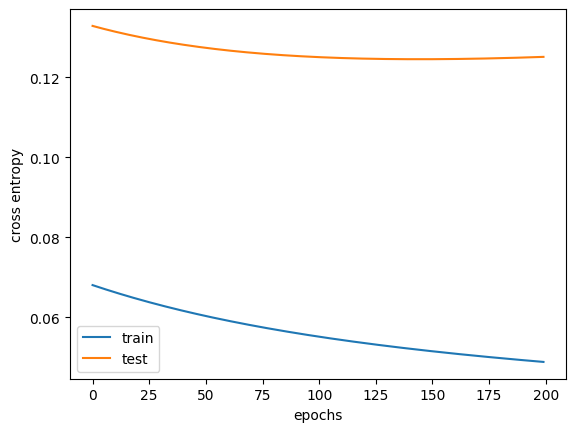

In [12]:
import matplotlib.pyplot as plt

%matplotlib inline
 
plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.legend()
plt.show()
 


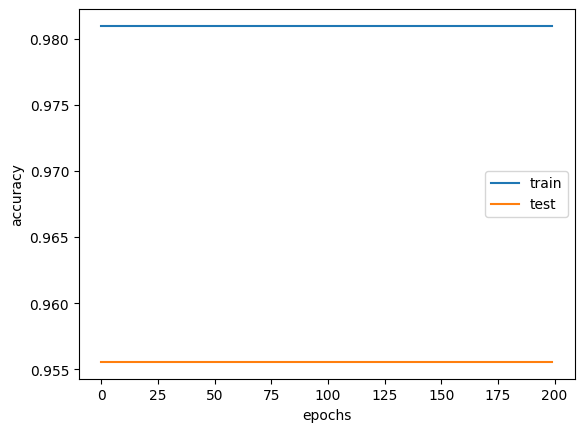

In [13]:
plt.plot(train_acc_hist, label="train")
plt.plot(test_acc_hist, label="test")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()